# Datenauswertung

## Importiere Bibliotheken

In [11]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [12]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit
from pre_processing import *
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
hide_toggle()

# Plotten von simulierten Daten und Fitting
    Fitting Funktion:P=a(h-hf)^m
    


In [13]:
m_slider = widgets.FloatSlider(min=1,max=2, step=0.1)
a_slider = widgets.FloatSlider(value=0.1, min=0.05,max=1, step=0.05)
noise_P_slider = widgets.FloatSlider(value=0.1, min=0,max=10, step=0.05)
fit_range_slider = widgets.FloatRangeSlider(value=[0.3, 0.95], min=0, max=1, step=0.05)
n_points_slider = widgets.IntSlider(value=100, min=0,max=1000, step=10)
h_f_slider = widgets.IntSlider(value=0, min=0,max=100, step=5)
h_max = 100 #[nm]
#h_f = 0
#noise_std_h = 0.1
#noise_h = np.random.normal(0,noise_std_h, n_points)


def plotfit(m=1.3, alpha=0.1, noise_std_P=0.5, fit_range=[0.3,0.95], n_points=100, h_f=0):
    h = np.linspace(0, h_max, n_points)#[nm]
    noise_P = np.random.normal(0,noise_std_P,n_points)
    P = alpha*(h - h_f)**m+noise_P     #[nN]
    plt.plot(h , P, label='simulated data')
    plt.xlabel('depth [nm]')
    plt.ylabel('Force [nN]')
    popt_log, pcov_log = fitting(h, np.log(P), fit_range, (0.1, 1, 0), fit_func=func_log) 
    popt_exp, pcov_exp = fitting(h, P, fit_range, (0.1,1,0), fit_func=func_exp)
    plt.plot(h, func_exp(h, *popt_log), label = 'log fit')
    plt.plot(h, func_exp(h, *popt_exp), label = 'power law fit')
    plt.legend()
             
    print('Kurvenparameter (alpha, m, hf:)',popt_log)
    print('Abweichung von Modellparametern (log fit):')
    print('\ndelta alpha=', 100*((alpha-popt_log[0])/alpha),'%')
    print('delta m =', 100*((m-popt_log[1])/m),'%')
    print('delta hf =', h_f-popt_log[2],'[nm]')
    print('\nAbweichung von Modellparametern (power law fit):')
    print('\ndelta alpha=', 100*((alpha-popt_exp[0])/alpha),'%')
    print('delta m =', 100*((m-popt_exp[1])/m),'%')
    print('delta hf =', h_f-popt_exp[2],'[nm]')

widgets.interact(plotfit, m=m_slider, alpha=a_slider, noise_std_P=noise_P_slider, fit_range=fit_range_slider,
                 n_points=n_points_slider, h_f=h_f_slider)

hide_toggle()

interactive(children=(FloatSlider(value=1.0, description='m', max=2.0, min=1.0), FloatSlider(value=0.1, descri…

## Ebenenfitting

Ebenengleichung: ax+by+d=z

Gradient: (dz/dx, dz/dy) = ((a),(b))
Ebenensteigung = sqrt(a^2+b^2)

### Mit simulierten Daten

solution: 0.325332 x + 0.603446 y + 4.929723 = z


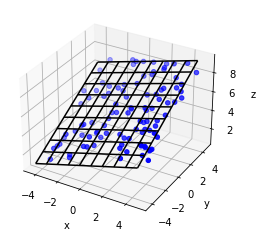

Ebenensteigung: 0.6855571565337132


In [14]:
# These constants are to create random data for the sake of this example
N_POINTS = 100
TARGET_X_SLOPE = 0.3
TARGET_y_SLOPE = 0.6
TARGET_OFFSET  = 5
EXTENTS = 5
NOISE = 0.5



# Create random data.
# In your solution, you would provide your own xs, ys, and zs data.
xs = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
ys = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
zs = []
for i in range(N_POINTS):
    zs.append(xs[i]*TARGET_X_SLOPE + \
              ys[i]*TARGET_y_SLOPE + \
              TARGET_OFFSET + np.random.normal(scale=NOISE))
    
# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)

# Manual solution
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

# Or use Scipy
# from scipy.linalg import lstsq
# fit, residual, rnk, s = lstsq(A, b)

print("solution: %f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
#print("errors: \n", errors)
#print("residual:", residual)

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#print(Z)

#compute slope of plane (gradient)
Z_grad = fit[0:2]
max_grad = np.linalg.norm(Z_grad)
print('Ebenensteigung:', max_grad)
hide_toggle()

### Mit realen Daten aus Array Antastung

solution: -0.006411 x + -0.001016 y + 3.815257 = z


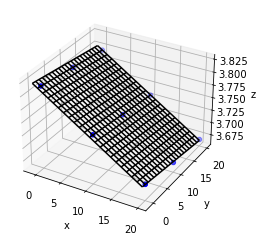

Ebenensteigung in [%]: 0.6490895412999664
Ebenensteigung in [°]: 0.37189568961562536


In [22]:
#data from modulus mapping (23.06.22)
xs = [0, 0, 0, 10, 10, 10, 20, 20, 20] #[um]
ys = [0, 10, 20, 20, 10, 0, 0, 10, 20]   #[um]
zs = [3.815748, 3.805186, 3.794780, 3.730393, 3.740052, 3.751712, 3.687332, 3.675042, 3.668683]   #[um]

# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)

# Manual solution
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

# Or use Scipy
#from scipy.linalg import lstsq
#fit, residual, rnk, s = lstsq(A, b)

print("solution: %f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
#print("errors: \n", errors)
#print("residual:", residual)

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#print(Z)

#compute slope of plane (gradient)
Z_grad = fit[0:2]
max_grad = np.linalg.norm(Z_grad)
max_deg = np.rad2deg(np.arctan(max_grad))
print('Ebenensteigung in [%]:', max_grad*100)
print('Ebenensteigung in [°]:', max_deg)
hide_toggle()